<center> <img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>    
<table>
    <th><font size=5>Специализация "Машинное обучение и анализ данных" от:</font></th>
    <th><img src="https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/11/ae0000b18911e5965623dd71776f15/mipt.png?auto=format%2Ccompress&dpr=1&w=200&h=100&fit=clip"/> </th>
    <th><img src="https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/fe/ab6f503b2b11e796ddbfacaf40b9e6/Yandex.jpg?auto=format%2Ccompress&dpr=1&w=200&h=100&fit=clip"/></th>
</table>

# <center> ПРОЕКТ: Идентификация пользователей по посещенным веб-страницам
# <center> АВТОР ПРОЕКТА: Дмитрий Шерешевский, *PhD*
##    
<center>Исходный материал: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

<img src='http://smartcity.eletsonline.com/wp-content/uploads/2017/04/digitalindia.png'>

# <center>ЧАСТЬ 2 из 6. 
# <center>Подготовка и первичный анализ данных
## <center> Введение

Во второй части мы продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии.
Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями. 

**Темы 2 части:**
 - Подготовка нескольких обучающих выборок для сравнения
 - Первичный анализ данных, проверка гипотез

**Используемые инструменты:**

   - [Доверительные интервалы для доли](https://www.coursera.org/learn/stats-for-data-analysis/lecture/3oi53/dovieritiel-nyie-intiervaly-dlia-doli)
   - [Биномиальный критерий для доли](https://www.coursera.org/learn/stats-for-data-analysis/lecture/JwmBw/binomial-nyi-kritierii-dlia-doli)
   - [Доверительные интервалы на основе бутстрепа](https://www.coursera.org/learn/stats-for-data-analysis/lecture/GZjW7/dovieritiel-nyie-intiervaly-na-osnovie-butstriepa)
   
**Кроме того, будут использоваться библиотеки Python [glob](https://docs.python.org/3/library/glob.html), [pickle](https://docs.python.org/2/library/pickle.html), [itertools](https://docs.python.org/3/library/itertools.html) и класс [csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) из `scipy.sparse`.**

## <center> 2.1. Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуем функцию *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция будет возвращать 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*

Детали:
- Модифицируем созданную в 1 части функцию *prepare_train_set*
- Некоторые сессии могут повторяться – оставим как есть, без удаления дубликатов
- Замерим время выполнения итераций цикла с помощью *time* из *time*, *tqdm* из *tqdm* или с помощью виджета [log_progress](https://github.com/alexanderkuk/log-progress) ([статья](https://habrahabr.ru/post/276725/) о нем на Хабрахабре)
- Добьемся, чтобы 150 файлов из *capstone_websites_data/150users/* обрабатывались за несколько секунд (в зависимости от входных параметров).

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Путь к данным
PATH_TO_DATA = ('../data')

In [3]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    ''' 
    Функция возвращает 2 объекта:
      - разреженную матрицу X_sparse (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из 
        session_length сайтов, а max(site_id) столбцов – количеству посещений site_id в сессии.
      - вектор y (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из X_sparse
    
    '''
    # инициализация
    y = np.array([0]).reshape(1, 1) # вектор ответов
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
        
    # считываем частотный словарь
    with open(site_freq_path, 'rb') as pkl_file:
        freq_vocabulary = pickle.load(pkl_file)
            
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_pd = pd.read_csv(path, header=0, index_col=0)
                
        # перекодируем site_string в site_id
        data = data_pd['site'].apply(lambda x: freq_vocabulary[x][0]).values.reshape(-1, 1)
        
        # формируем модифицированные данные с учетом окна для 1 текущего юзера data_mod_user_id
        row = int(data.size / window_size) + 1 if data.size % window_size != 0 \
                                                               else int(data.size / window_size)
        # добавим сразу нули
        data = np.vstack((data, np.zeros([session_length, 1])))
        data_mod_user_id = [data[w * window_size + sess, 0] for w in range(row) for sess in range(session_length)]   
                
        # накапливаем модифицированный список закодированных сайтов с учетом окна
        data_mod.extend(data_mod_user_id)
                
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = np.zeros([1, row]) + user_id # forming columns with user_id
        y = np.hstack((y, col_user_id))
        
            
    # формируем разреженную матрицу X_sparse
    X_sparse = csr_matrix((np.ones(len(data_mod)), 
                           data_mod, 
                           np.arange(int(len(data_mod) / session_length) + 1) * session_length), dtype=int)[:, 1:]
                           
    # нулевой столбец, который отвечает за нули, исключаем
    
    return X_sparse, y[0, 1:].astype(int) # исключаем нулевой нуль

**Применим полученную функцию с параметрами *session_length=5* и *window_size=3* к игрушечному примеру. Убедимся, что все работает как надо.**

In [4]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

A Jupyter Widget

In [5]:
X_toy_s5_w3.todense()

matrix([[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [6]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

**Запустим созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуем все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.**

**Для контроля, запишем в список *data_lengths* число строк во всех полученных разреженных матрицах (16 значений). Некоторые строки могут совпадать, поскольку длина строк определяется только размером окна (не сессии).**

In [7]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'{}users'.format(num_users)), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_{}users.pkl'.format(num_users)),
                                                       session_length=session_length, window_size=window_size)
            with open(os.path.join(PATH_TO_DATA, 
                                'X_sparse_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size)), 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 
                                   'y_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size)), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)

            data_lengths.append(X_sparse.shape[0])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Wall time: 1min 19s


**Посмотрим для контроля на числа из списка *data_lengths* (через пробел).**

In [9]:
' '.join(np.array(data_lengths).astype(str))

'14061 20087 20087 20087 28118 28118 28118 28118 137019 195712 195712 195712 273957 273957 273957 273957'

In [11]:
print('Число уникальных чисел в `data_lengths`:', len(set(data_lengths)))

Число уникальных чисел в `data_lengths`: 6


## <center> 2.2. Первичный анализ данных, проверка гипотез

**Считаем в DataFrame подготовленный в 1 части файл `train_data_10users.csv`. Далее будем работать с ним.**

In [25]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [26]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,1,2,3,4,3,3,4,3,5,3,31
1,6,7,8,9,3,10,11,12,13,14,31
2,14,4,14,14,15,16,6,17,18,14,31
3,19,20,19,14,14,14,14,21,22,23,31
4,24,14,15,25,26,27,28,29,30,29,31


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


**Распределение целевого класса:**

In [28]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [29]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [30]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

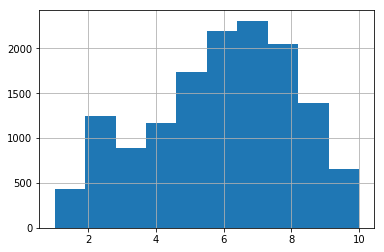

In [31]:
pd.Series(num_unique_sites).hist();

**Проверим с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально. Сделайте вывод. Ответом на второй вопрос в тесте будет файл со словом "YES" или "NO" в зависимости от того, распределено ли нормально число уникальных сайтов в сессии.**

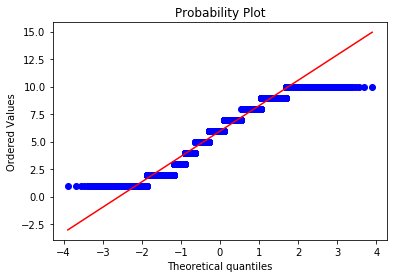

In [32]:
plt.figure(figsize=(6,4))
stats.probplot(pd.Series(num_unique_sites), dist="norm", plot=plt)
plt.show()

In [33]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(pd.Series(num_unique_sites)))

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


**ВЫВОД:**   
Видим, что согласно графического теста **Ку-Ку-график** и критерия **Шапиро-Уилка** у распределения числа уникальных сайтов в сессии нормальность **не наблюдается** (p-value << 0.05).   
Это дает основание предполагать, что этот параметр для различных пользователей имеет высокую степень **уникальности** и, следовательно, может быть достаточно **информативным признаком** в задаче идентификации пользователя.

**Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Для этого проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратим внимание, что альтернатива тому, что доля равна 95% –  одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.**

In [37]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
has_two_similar.mean()

0.95370172818433963

In [39]:
pi_val = stats.binom_test(has_two_similar.sum(), n=has_two_similar.shape[0], p=0.95, alternative = 'greater')
pi_val

0.022076537690726782

Поскольку **p-value < 0.05**, то на уровне **0.05** гипотеза **отвергается**.

**Для наглядности построим для этой доли 95% доверительный интервал Уилсона.**

In [41]:
wilson_interval = proportion_confint(has_two_similar.sum(), has_two_similar.shape[0], method = 'wilson')
print('[{} {}]'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)))

[0.95 0.957]


**Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.**

In [45]:
site_freqs = pd.Series(train_df.drop('user_id', axis=1).values.ravel()).value_counts()

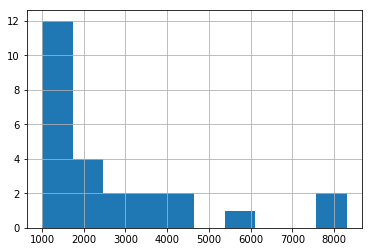

In [46]:
site_freqs[site_freqs >= 1000].hist();

**Построим 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Будем использовать столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Подвыборки возьмем из посчитанного списка частот посещений сайтов. Учтем, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлим границы интервала до 3 знаков после запятой.**

In [47]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [48]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [51]:
data = site_freqs.values
n_samples = site_freqs.index.max()

median_scores = list(map(np.mean, get_bootstrap_samples(data, n_samples, random_seed=17)))
boundaries = stat_intervals(median_scores, 0.05).round(3)

print("95% confidence interval:",  boundaries)

95% confidence interval: [ 22.514  35.756]


## Что еще можно сделать

- можно дополнительно рассматривать сессии с параметром – длиной сессии по времени. И составить выборки, скажем, для 5-, 10-, 15- и 20-минутных сессий (это может пригодится в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass)
- можно провести больше первичного анализа и проверять прочие интересные гипотезы (а больше их появится после создания признаков в следующей части)

В 3 части мы займемся визуальным анализом данных и построением признаков.